# LVV-T2190 Plots

This notebook is designed to query the EFD and make diagnostics plots for the execution of Test Case [LVV-T2190].  
This test case consists of applying `1 um` to the 7th component of the Annular Zernike Coefficient.  
Then it resets the corrections and applies `2 um` to the same component. 

This means that we can expect to have three values for each metric (at +1um, at 0um, and at +2um).  
We can expect that that each telemetry on the third row will be twice the values of the first row.  
If they are not, it can mean that the corrections are not properly calculated or that their relationship with the Zernike Coefficients are not linear.

When executing the tests, duplicate the notebook and rename it using the test execution name.

[LVV-T2190]: https://jira.lsstcorp.org/secure/Tests.jspa#/testCase/LVV-T2190

In [ ]:
from lsst.ts import utils

# Extract your name from the Jupyter Hub
__executed_by__ = os.environ["JUPYTERHUB_USER"]  

# Extract execution date
__executed_on__ = utils.astropy_time_from_tai_unix(utils.current_tai())
__executed_on__.format = "isot"

# This is used later to define where Butler stores the images
summit = os.environ["LSST_DDS_PARTITION_PREFIX"] == "summit"

print(f"\nExecuted by {__executed_by__} on {__executed_on__}."
      f"\n  At the summit? {summit}")


Executed by hdrass on 2022-06-17T18:08:47.307.
  At the summit? True


## Set Up 

In [ ]:
import os 
import sys
import logging

import numpy as np
import pandas as pd

from astropy.time import Time
from astropy import units as u
from datetime import timedelta, datetime

import lsst_efd_client

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from pandas.plotting import register_matplotlib_converters

In [ ]:
%config Application.log_level="ERROR"

In [ ]:
%matplotlib inline

## Time window for the test execution.

Update the cells below to reflect the time when the test was executed.  
This is the time window used to query the EFD.  

In [53]:
test_execution = "LVV-E1868"
time_start_utc = "2022-06-17T17:20:00.0"
time_end_utc = "2022-06-17T18:11:06.330"

#test_execution = "LVV-E1868"
#time_start_utc = "2022-05-13T17:06:00.000"
#time_end_utc = "2022-05-13T17:11:06.330"

# test_execution = "LVV-E1788"
# time_start_utc = "2022-04-08T14:20:42"
# time_end_utc = "2022-04-08T15:21:31"

In [54]:
start = Time(time_start_utc, format="isot", scale="utc")
end = Time(time_end_utc, format="isot", scale="utc")

## Initialization

We start by setting up a logger for the notebook and configuring the EFD Client.

In [55]:
log = logging.getLogger("LVV-T2190")
log.setLevel(logging.DEBUG)

In [56]:
lsst_efd_client.EfdClient.list_efd_names()

['tucson_teststand_efd',
 'test_efd',
 'summit_efd',
 'ncsa_teststand_efd',
 'ldf_stable_efd',
 'ldf_int_efd',
 'base_efd']

In [57]:
efd_name = "summit_efd"

In [58]:
client = lsst_efd_client.EfdClient(efd_name)

In [59]:
start.strftime("%m/%d/%Y, %H:%M:%S"), end.strftime("%m/%d/%Y, %H:%M:%S") 

('06/17/2022, 17:20:00', '06/17/2022, 18:11:06')

In [60]:
log.debug(f"{start.utc}, {end}")

In [61]:
os.makedirs("plots", exist_ok=True)

## Displaying results


### Display degrees of freedom

The degrees of freedom are the first step performed by the OFC in converting the wavefront errors into corrections. 

It is composed of two parts, the "aggregated" and the "visit" degrees of freedom.
The "aggregated" is the combination of all corrections computed so far whereas the "visit" contains only the degrees of freedom from the last correction.

These values are published as vectors of 50 elements each in the "degreeOfFreedom" event.
As with the `annularZernikeCoeff` case above we need to query them individually and then build the vectors afterwards.

In [62]:
degrees_of_freedom = await client.select_time_series(
    'lsst.sal.MTAOS.logevent_degreeOfFreedom', 
    [f"aggregatedDoF{i}" for i in range(50)] + [f"visitDoF{i}" for i in range(50)], 
    start.utc, 
    end.utc
)

In [63]:
degrees_of_freedom

,aggregatedDoF0,aggregatedDoF1,aggregatedDoF2,aggregatedDoF3,aggregatedDoF4,aggregatedDoF5,aggregatedDoF6,aggregatedDoF7,aggregatedDoF8,aggregatedDoF9,...,visitDoF40,visitDoF41,visitDoF42,visitDoF43,visitDoF44,visitDoF45,visitDoF46,visitDoF47,visitDoF48,visitDoF49
2022-06-17 18:01:45.998000+00:00,0.169121,0.054919,-71.852360,-11.856128,-0.008164,0.008265,-0.025150,37.968733,-0.419880,-0.002405,...,-0.000021,0.000042,0.000041,0.000018,0.000219,7.525153e-08,5.763935e-08,-1.898672e-06,0.000464,0.001309
2022-06-17 18:01:57.190000+00:00,0.216516,0.074500,-128.192546,-20.266218,-0.012232,0.090462,-0.039064,62.612988,0.018287,-0.002876,...,-0.000024,-0.000058,0.000039,0.000002,0.000153,2.873308e-08,2.691570e-08,-3.683317e-08,0.000204,0.000577
2022-06-17 18:01:57.751000+00:00,0.169121,0.054919,-71.852360,-11.856128,-0.008164,0.008265,-0.025150,37.968733,-0.419880,-0.002405,...,-0.000021,0.000042,0.000041,0.000018,0.000219,7.525153e-08,5.763935e-08,-1.898672e-06,0.000464,0.001309
2022-06-17 18:02:06.424000+00:00,0.216516,0.074500,-128.192546,-20.266218,-0.012232,0.090462,-0.039064,62.612988,0.018287,-0.002876,...,-0.000024,-0.000058,0.000039,0.000002,0.000153,2.873308e-08,2.691570e-08,-3.683317e-08,0.000204,0.000577
2022-06-17 18:02:12.143000+00:00,0.169121,0.054919,-71.852360,-11.856128,-0.008164,0.008265,-0.025150,37.968733,-0.419880,-0.002405,...,-0.000021,0.000042,0.000041,0.000018,0.000219,7.525153e-08,5.763935e-08,-1.898672e-06,0.000464,0.001309
2022-06-17 18:02:18.868000+00:00,0.385636,0.129420,-200.044907,-32.122346,-0.020396,0.098726,-0.064214,100.581721,-0.401594,-0.005281,...,-0.000045,-0.000016,0.000080,0.000020,0.000372,1.039846e-07,8.455505e-08,-1.935505e-06,0.000668,0.001886
2022-06-17 18:03:56.573000+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
2022-06-17 18:04:11.694000+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
2022-06-17 18:07:15.282000+00:00,0.169121,0.054919,-71.852360,-11.856128,-0.008164,0.008265,-0.025150,37.968733,-0.419880,-0.002405,...,-0.000021,0.000042,0.000041,0.000018,0.000219,7.525153e-08,5.763935e-08,-1.898672e-06,0.000464,0.001309


During the [LVV-T2190] test, we first issue an `1 um` aberration, reset the the corrections, and then issue a `2 um` aberration.  
Common sense says that row 2 and row 0 must have a factor of 2 of difference. 

In [64]:
degrees_of_freedom.iloc[2] / degrees_of_freedom.iloc[0]

aggregatedDoF0    1.0
aggregatedDoF1    1.0
aggregatedDoF2    1.0
aggregatedDoF3    1.0
aggregatedDoF4    1.0
                 ... 
visitDoF45        1.0
visitDoF46        1.0
visitDoF47        1.0
visitDoF48        1.0
visitDoF49        1.0
Length: 100, dtype: float64

We need to unpack the data from the EFD query into vectors that are easier to plot.

In [65]:
aggregated_dof = np.array([degrees_of_freedom[f"aggregatedDoF{i}"] for i in range(50)]).T
visit_dof = np.array([degrees_of_freedom[f"visitDoF{i}"] for i in range(50)]).T

In [66]:
comp_dof_idx = dict(
            m2HexPos=dict(
                startIdx=0,
                idxLength=5,
                state0name="M2Hexapod",
            ),
            camHexPos=dict(
                startIdx=5,
                idxLength=5,
                state0name="cameraHexapod",
            ),
            M1M3Bend=dict(
                startIdx=10, idxLength=20, state0name="M1M3Bending", rot_mat=1.0
            ),
            M2Bend=dict(startIdx=30, idxLength=20, state0name="M2Bending", rot_mat=1.0),
        )

And we finally plot them.

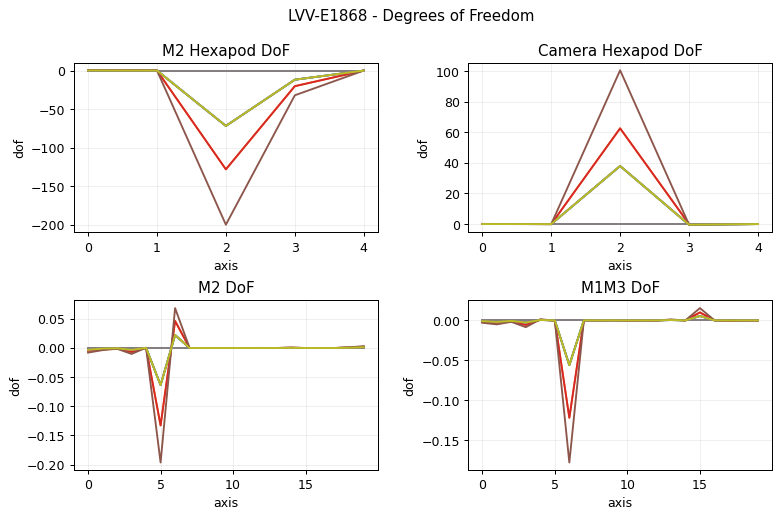

In [67]:
fig, axes = plt.subplots(2,2, figsize=(10,6), dpi=90)

for i in range(len(aggregated_dof)):
    
    axes[0][0].plot(
        aggregated_dof[i][
            comp_dof_idx["m2HexPos"]["startIdx"]:
            comp_dof_idx["m2HexPos"]["startIdx"]+comp_dof_idx["m2HexPos"]["idxLength"]
        ]
    )
    
    axes[0][1].plot(
        aggregated_dof[i][
            comp_dof_idx["camHexPos"]["startIdx"]:
            comp_dof_idx["camHexPos"]["startIdx"]+comp_dof_idx["camHexPos"]["idxLength"]
        ]
    )

    axes[1][0].plot(
        aggregated_dof[i][
            comp_dof_idx["M2Bend"]["startIdx"]:
            comp_dof_idx["M2Bend"]["startIdx"]+comp_dof_idx["M2Bend"]["idxLength"]
        ]
    )

    axes[1][1].plot(
        aggregated_dof[i][
            comp_dof_idx["M1M3Bend"]["startIdx"]:
            comp_dof_idx["M1M3Bend"]["startIdx"]+comp_dof_idx["M1M3Bend"]["idxLength"]
        ]
    )

ax_titles = ["M2 Hexapod DoF",  "Camera Hexapod DoF", "M2 DoF", "M1M3 DoF"]
for i in range(4):

    r = i // 2
    c = i % 2

    axes[r][c].set_title(ax_titles[i])
    axes[r][c].set_xlabel("axis")
    axes[r][c].set_ylabel("dof")
    axes[r][c].grid("-", alpha=0.2)

fig.suptitle(f"{test_execution} - Degrees of Freedom")
fig.patch.set_facecolor('white')
plt.subplots_adjust(hspace=0.4, wspace=0.3)

fig.savefig(f"plots/{test_execution}_dof.png")

## Step 8

### Display Camera Hexapod Correction

In [68]:
cam_hexapod_correction_computed_xyz = await client.select_time_series(
    'lsst.sal.MTAOS.logevent_cameraHexapodCorrection', 
    ["x", "y", "z"], 
    start.utc, 
    end.utc
)

cam_hexapod_correction_computed_uv = await client.select_time_series(
    'lsst.sal.MTAOS.logevent_cameraHexapodCorrection', 
    ["u", "v"], 
    start.utc, 
    end.utc
)

In [69]:
cam_hexapod_correction_applied_xyz = await client.select_time_series(
    'lsst.sal.MTHexapod.logevent_uncompensatedPosition', 
    ["x", "y", "z", "MTHexapodID"], 
    start.utc, 
    end.utc,
    index=1
)

cam_hexapod_correction_applied_uv = await client.select_time_series(
    'lsst.sal.MTHexapod.logevent_uncompensatedPosition', 
    ["u", "v", "MTHexapodID"], 
    start.utc, 
    end.utc,
    index=1
)

In [70]:
cam_hexapod_correction_command_xyz = await client.select_time_series(
    'lsst.sal.MTHexapod.command_move', 
    ["x", "y", "z", "MTHexapodID"], 
    start.utc, 
    end.utc,
    index=1
)

cam_hexapod_correction_command_uv = await client.select_time_series(
    'lsst.sal.MTHexapod.command_move', 
    ["u", "v", "MTHexapodID"], 
    start.utc, 
    end.utc,
    index=1
)

In [71]:
cam_hexapod_correction_computed_xyz

,x,y,z
2022-06-17 18:01:46.006000+00:00,0.025150,37.968733,-0.008265
2022-06-17 18:01:57.191000+00:00,0.039064,62.612988,-0.090462
2022-06-17 18:02:06.425000+00:00,0.039064,62.612988,-0.090462
2022-06-17 18:02:12.144000+00:00,0.025150,37.968733,-0.008265
2022-06-17 18:02:18.918000+00:00,0.064214,100.581721,-0.098726
2022-06-17 18:03:56.574000+00:00,0.000000,0.000000,0.000000
2022-06-17 18:04:11.696000+00:00,0.000000,0.000000,0.000000
2022-06-17 18:07:15.292000+00:00,0.025150,37.968733,-0.008265


In [72]:
cam_hexapod_correction_computed_uv

,u,v
2022-06-17 18:01:46.006000+00:00,0.000117,6.679176e-07
2022-06-17 18:01:57.191000+00:00,-0.000005,7.989896e-07
2022-06-17 18:02:06.425000+00:00,-0.000005,7.989896e-07
2022-06-17 18:02:12.144000+00:00,0.000117,6.679176e-07
2022-06-17 18:02:18.918000+00:00,0.000112,1.466907e-06
2022-06-17 18:03:56.574000+00:00,0.000000,0.000000e+00
2022-06-17 18:04:11.696000+00:00,0.000000,0.000000e+00
2022-06-17 18:07:15.292000+00:00,0.000117,6.679176e-07


In [73]:
cam_hexapod_correction_applied_xyz

,x,y,z,MTHexapodID
2022-06-17 18:01:46.191000+00:00,0.025150,37.968733,-0.008265,1
2022-06-17 18:01:57.347000+00:00,0.039064,62.612988,-0.090462,1
2022-06-17 18:01:57.897000+00:00,0.025150,37.968733,-0.008265,1
2022-06-17 18:02:06.550000+00:00,0.039064,62.612988,-0.090462,1
2022-06-17 18:02:12.254000+00:00,0.025150,37.968733,-0.008265,1
2022-06-17 18:02:19.056000+00:00,0.064214,100.581721,-0.098726,1
2022-06-17 18:04:06.953000+00:00,0.000000,0.000000,0.000000,1
2022-06-17 18:07:27.591000+00:00,0.025150,37.968733,-0.008265,1


In [74]:
cam_hexapod_correction_applied_uv

,u,v,MTHexapodID
2022-06-17 18:01:46.191000+00:00,0.000117,6.679176e-07,1
2022-06-17 18:01:57.347000+00:00,-0.000005,7.989896e-07,1
2022-06-17 18:01:57.897000+00:00,0.000117,6.679176e-07,1
2022-06-17 18:02:06.550000+00:00,-0.000005,7.989896e-07,1
2022-06-17 18:02:12.254000+00:00,0.000117,6.679176e-07,1
2022-06-17 18:02:19.056000+00:00,0.000112,1.466907e-06,1
2022-06-17 18:04:06.953000+00:00,0.000000,0.000000e+00,1
2022-06-17 18:07:27.591000+00:00,0.000117,6.679176e-07,1


In [75]:
cam_hexapod_correction_command_xyz

,x,y,z,MTHexapodID
2022-06-17 18:01:00.298000+00:00,0.000000,0.000000,0.000000,1
2022-06-17 18:01:57.245000+00:00,0.039064,62.612988,-0.090462,1
2022-06-17 18:01:57.751000+00:00,0.025150,37.968733,-0.008265,1
2022-06-17 18:02:12.180000+00:00,0.025150,37.968733,-0.008265,1
2022-06-17 18:02:18.954000+00:00,0.064214,100.581721,-0.098726,1
2022-06-17 18:07:27.520000+00:00,0.025150,37.968733,-0.008265,1


In [76]:
cam_hexapod_correction_command_uv

,u,v,MTHexapodID
2022-06-17 18:01:00.298000+00:00,0.000000,0.000000e+00,1
2022-06-17 18:01:57.245000+00:00,-0.000005,7.989896e-07,1
2022-06-17 18:01:57.751000+00:00,0.000117,6.679176e-07,1
2022-06-17 18:02:12.180000+00:00,0.000117,6.679176e-07,1
2022-06-17 18:02:18.954000+00:00,0.000112,1.466907e-06,1
2022-06-17 18:07:27.520000+00:00,0.000117,6.679176e-07,1


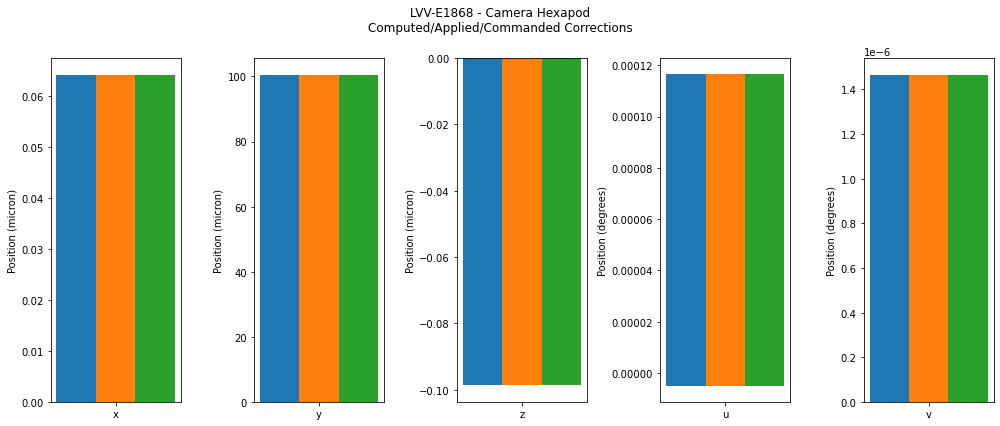

In [77]:
fig, axs = plt.subplots(figsize=(14, 6), ncols=5)

for panel, label in enumerate("xyz"):

    ax = plt.subplot(1,5,panel+1)

    ax.bar(
        [-0.5],
        cam_hexapod_correction_computed_xyz[label],
        width=0.5
    )
    ax.bar(    
        [0.],
        cam_hexapod_correction_applied_xyz[label],
        width=0.5
    )

    ax.bar(    
        [0.5],
        cam_hexapod_correction_command_xyz[label],
        width=0.5
    )
    
    ax.set_xticks([0])
    ax.set_xticklabels([label])
    ax.set_ylabel("Position (micron)")

for panel, label in enumerate("uv"):

    ax = plt.subplot(1,5,panel+4)
    
    x = [0.]

    b0 = ax.bar(
        [-0.5],
        cam_hexapod_correction_computed_uv[label],
        width=0.5,
    )
    
    b1 = ax.bar(    
        [0.],
        cam_hexapod_correction_applied_uv[label],
        width=0.5, 
    )

    b2 = ax.bar(    
        [0.5],
        cam_hexapod_correction_command_uv[label],
        width=0.5, 
    )

    ax.set_xticks([0])
    ax.set_xticklabels([label])
    ax.set_ylabel("Position (degrees)")
    
fig.suptitle(f"{test_execution} - Camera Hexapod\nComputed/Applied/Commanded Corrections")
fig.tight_layout(h_pad=0.3)
fig.patch.set_facecolor('white')

fig.savefig(f"plots/{test_execution}_camera_hexapod.png")

### Display M2 Hexapod Correction

In [78]:
m2_hexapod_correction_computed_xyz = await client.select_time_series(
    'lsst.sal.MTAOS.logevent_m2HexapodCorrection', 
    ["x", "y", "z"], 
    start.utc, 
    end.utc
)

m2_hexapod_correction_computed_uv = await client.select_time_series(
    'lsst.sal.MTAOS.logevent_m2HexapodCorrection', 
    ["u", "v"], 
    start.utc, 
    end.utc
)

In [79]:
m2_hexapod_correction_applied_xyz = await client.select_time_series(
    'lsst.sal.MTHexapod.logevent_uncompensatedPosition', 
    ["x", "y", "z", "MTHexapodID"], 
    start.utc, 
    end.utc,
    index=2
)

m2_hexapod_correction_applied_uv = await client.select_time_series(
    'lsst.sal.MTHexapod.logevent_uncompensatedPosition', 
    ["u", "v", "MTHexapodID"], 
    start.utc, 
    end.utc,
    index=2
)

In [80]:
m2_hexapod_correction_command_xyz = await client.select_time_series(
    'lsst.sal.MTHexapod.command_move', 
    ["x", "y", "z", "MTHexapodID"], 
    start.utc, 
    end.utc,
    index=2
)

m2_hexapod_correction_command_uv = await client.select_time_series(
    'lsst.sal.MTHexapod.command_move', 
    ["u", "v", "MTHexapodID"], 
    start.utc, 
    end.utc,
    index=2
)

In [81]:
m2_hexapod_correction_command_xyz

,x,y,z,MTHexapodID
2022-06-17 18:01:46.106000+00:00,-0.054919,-71.852360,-0.169121,2
2022-06-17 18:01:57.244000+00:00,-0.074500,-128.192546,-0.216516,2
2022-06-17 18:02:06.464000+00:00,-0.074500,-128.192546,-0.216516,2
2022-06-17 18:04:06.850000+00:00,0.000000,0.000000,0.000000,2
2022-06-17 18:07:27.519000+00:00,-0.054919,-71.852360,-0.169121,2


In [82]:
m2_hexapod_correction_computed_xyz

,x,y,z
2022-06-17 18:01:45.999000+00:00,-0.054919,-71.852360,-0.169121
2022-06-17 18:01:57.190000+00:00,-0.074500,-128.192546,-0.216516
2022-06-17 18:02:06.425000+00:00,-0.074500,-128.192546,-0.216516
2022-06-17 18:02:12.144000+00:00,-0.054919,-71.852360,-0.169121
2022-06-17 18:02:18.869000+00:00,-0.129420,-200.044907,-0.385636
2022-06-17 18:03:56.573000+00:00,0.000000,0.000000,0.000000
2022-06-17 18:04:11.695000+00:00,0.000000,0.000000,0.000000
2022-06-17 18:07:15.283000+00:00,-0.054919,-71.852360,-0.169121


In [83]:
m2_hexapod_correction_applied_xyz

,x,y,z,MTHexapodID
2022-06-17 18:01:46.108000+00:00,-0.054919,-71.852360,-0.169121,2
2022-06-17 18:02:06.466000+00:00,-0.074500,-128.192546,-0.216516,2
2022-06-17 18:02:12.181000+00:00,-0.054919,-71.852360,-0.169121,2
2022-06-17 18:02:18.955000+00:00,-0.129420,-200.044907,-0.385636,2
2022-06-17 18:04:06.852000+00:00,0.000000,0.000000,0.000000,2
2022-06-17 18:07:27.521000+00:00,-0.054919,-71.852360,-0.169121,2


In [84]:
m2_hexapod_correction_command_uv

,u,v,MTHexapodID
2022-06-17 18:01:46.106000+00:00,0.003293,0.000002,2
2022-06-17 18:01:57.244000+00:00,0.005630,0.000003,2
2022-06-17 18:02:06.464000+00:00,0.005630,0.000003,2
2022-06-17 18:04:06.850000+00:00,0.000000,0.000000,2
2022-06-17 18:07:27.519000+00:00,0.003293,0.000002,2


In [85]:
m2_hexapod_correction_computed_uv

,u,v
2022-06-17 18:01:45.999000+00:00,0.003293,0.000002
2022-06-17 18:01:57.190000+00:00,0.005630,0.000003
2022-06-17 18:02:06.425000+00:00,0.005630,0.000003
2022-06-17 18:02:12.144000+00:00,0.003293,0.000002
2022-06-17 18:02:18.869000+00:00,0.008923,0.000006
2022-06-17 18:03:56.573000+00:00,0.000000,0.000000
2022-06-17 18:04:11.695000+00:00,0.000000,0.000000
2022-06-17 18:07:15.283000+00:00,0.003293,0.000002


In [86]:
m2_hexapod_correction_applied_uv

,u,v,MTHexapodID
2022-06-17 18:01:46.108000+00:00,0.003293,0.000002,2
2022-06-17 18:02:06.466000+00:00,0.005630,0.000003,2
2022-06-17 18:02:12.181000+00:00,0.003293,0.000002,2
2022-06-17 18:02:18.955000+00:00,0.008923,0.000006,2
2022-06-17 18:04:06.852000+00:00,0.000000,0.000000,2
2022-06-17 18:07:27.521000+00:00,0.003293,0.000002,2


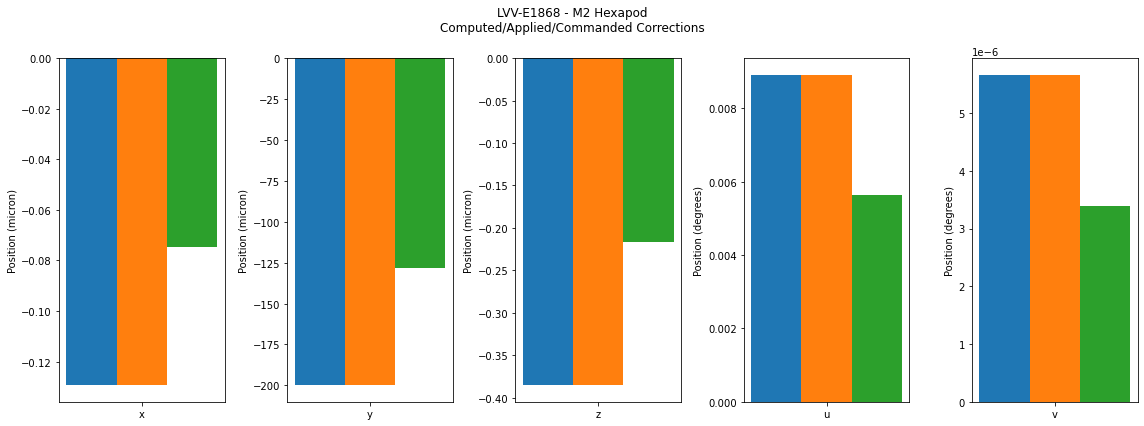

In [87]:
fig, axs = plt.subplots(figsize=(16, 6), ncols=5)

for panel, label in enumerate("xyz"):

    ax = axs[panel]
    
    ax.bar(
        [-0.5],
        m2_hexapod_correction_computed_xyz[label],
        width=0.5
    )
    
    ax.bar(    
        [0.],
        m2_hexapod_correction_applied_xyz[label],
        width=0.5
    )

    ax.bar(    
        [0.5],
        m2_hexapod_correction_command_xyz[label],
        width=0.5
    )

    ax.set_xticks([0])
    ax.set_xticklabels([label])
    ax.set_ylabel("Position (micron)")

    
for panel, label in enumerate("uv"):

    ax = axs[panel + 3]
    
    ax.bar(
        [-0.5],
        m2_hexapod_correction_computed_uv[label],
        width=0.5
    )
    
    ax.bar(    
        [0.],
        m2_hexapod_correction_applied_uv[label],
        width=0.5
    )

    ax.bar(    
        [0.5],
        m2_hexapod_correction_command_uv[label],
        width=0.5
    )

    ax.set_xticks([0])
    ax.set_xticklabels([label])
    ax.set_ylabel("Position (degrees)")


fig.suptitle(f"{test_execution} - M2 Hexapod\nComputed/Applied/Commanded Corrections")
fig.tight_layout(h_pad=0.3)
fig.patch.set_facecolor('white')

fig.savefig(f"plots/{test_execution}_m2_hexapod.png")

### Display M2 Correction

In [88]:
m2_correction = await client.select_time_series(
    'lsst.sal.MTAOS.logevent_m2Correction', 
    [f"zForces{i}" for i in range(72)], 
    start.utc, 
    end.utc
)

In [89]:
m2_correction

,zForces0,zForces1,zForces2,zForces3,zForces4,zForces5,zForces6,zForces7,zForces8,zForces9,...,zForces62,zForces63,zForces64,zForces65,zForces66,zForces67,zForces68,zForces69,zForces70,zForces71
2022-06-17 18:01:46.008000+00:00,-0.759188,-0.741219,-0.704368,-0.630182,-0.518267,-0.390221,-0.240212,-0.079020,0.083761,0.241742,...,-0.776518,-0.843476,-0.782143,-0.612518,-0.391572,-0.138743,0.136610,0.387046,0.604225,0.773663
2022-06-17 18:01:57.192000+00:00,-1.484869,-1.450552,-1.375108,-1.229742,-1.015420,-0.767578,-0.476014,-0.158691,0.164762,0.477563,...,-1.799385,-1.939438,-1.806488,-1.430485,-0.913980,-0.318616,0.318486,0.910369,1.421071,1.795960
2022-06-17 18:02:06.427000+00:00,-1.484869,-1.450552,-1.375108,-1.229742,-1.015420,-0.767578,-0.476014,-0.158691,0.164762,0.477563,...,-1.799385,-1.939438,-1.806488,-1.430485,-0.913980,-0.318616,0.318486,0.910369,1.421071,1.795960
2022-06-17 18:02:12.145000+00:00,-0.759188,-0.741219,-0.704368,-0.630182,-0.518267,-0.390221,-0.240212,-0.079020,0.083761,0.241742,...,-0.776518,-0.843476,-0.782143,-0.612518,-0.391572,-0.138743,0.136610,0.387046,0.604225,0.773663
2022-06-17 18:02:18.919000+00:00,-2.244057,-2.191770,-2.079476,-1.859924,-1.533687,-1.157800,-0.716226,-0.237711,0.248523,0.719305,...,-2.575903,-2.782914,-2.588631,-2.043003,-1.305551,-0.457359,0.455096,1.297415,2.025296,2.569623
2022-06-17 18:03:56.575000+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-06-17 18:04:11.697000+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-06-17 18:07:15.293000+00:00,-0.759188,-0.741219,-0.704368,-0.630182,-0.518267,-0.390221,-0.240212,-0.079020,0.083761,0.241742,...,-0.776518,-0.843476,-0.782143,-0.612518,-0.391572,-0.138743,0.136610,0.387046,0.604225,0.773663


In [90]:
m2_correction_applied = await client.select_time_series(
    'lsst.sal.MTM2.command_applyForces', 
    [f"axial{i}" for i in range(72)], 
    start.utc, 
    end.utc
)

In [91]:
m2_correction_applied

,axial0,axial1,axial2,axial3,axial4,axial5,axial6,axial7,axial8,axial9,...,axial62,axial63,axial64,axial65,axial66,axial67,axial68,axial69,axial70,axial71
2022-06-17 18:01:00.298000+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-06-17 18:01:46.106000+00:00,-0.759188,-0.741219,-0.704368,-0.630182,-0.518267,-0.390221,-0.240212,-0.079020,0.083761,0.241742,...,-0.776518,-0.843476,-0.782143,-0.612518,-0.391572,-0.138743,0.136610,0.387046,0.604225,0.773663
2022-06-17 18:01:57.245000+00:00,-1.484869,-1.450552,-1.375108,-1.229742,-1.015420,-0.767578,-0.476014,-0.158691,0.164762,0.477563,...,-1.799385,-1.939438,-1.806488,-1.430485,-0.913980,-0.318616,0.318486,0.910369,1.421071,1.795960
2022-06-17 18:01:57.898000+00:00,-0.759188,-0.741219,-0.704368,-0.630182,-0.518267,-0.390221,-0.240212,-0.079020,0.083761,0.241742,...,-0.776518,-0.843476,-0.782143,-0.612518,-0.391572,-0.138743,0.136610,0.387046,0.604225,0.773663
2022-06-17 18:02:06.464000+00:00,-1.484869,-1.450552,-1.375108,-1.229742,-1.015420,-0.767578,-0.476014,-0.158691,0.164762,0.477563,...,-1.799385,-1.939438,-1.806488,-1.430485,-0.913980,-0.318616,0.318486,0.910369,1.421071,1.795960
2022-06-17 18:02:12.180000+00:00,-0.759188,-0.741219,-0.704368,-0.630182,-0.518267,-0.390221,-0.240212,-0.079020,0.083761,0.241742,...,-0.776518,-0.843476,-0.782143,-0.612518,-0.391572,-0.138743,0.136610,0.387046,0.604225,0.773663
2022-06-17 18:02:18.954000+00:00,-2.244057,-2.191770,-2.079476,-1.859924,-1.533687,-1.157800,-0.716226,-0.237711,0.248523,0.719305,...,-2.575903,-2.782914,-2.588631,-2.043003,-1.305551,-0.457359,0.455096,1.297415,2.025296,2.569623
2022-06-17 18:04:06.851000+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-06-17 18:07:27.520000+00:00,-0.759188,-0.741219,-0.704368,-0.630182,-0.518267,-0.390221,-0.240212,-0.079020,0.083761,0.241742,...,-0.776518,-0.843476,-0.782143,-0.612518,-0.391572,-0.138743,0.136610,0.387046,0.604225,0.773663


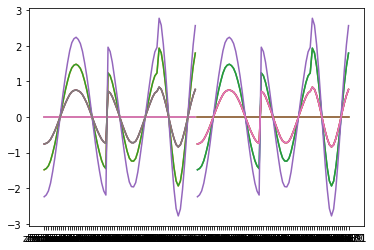

In [92]:
plt.plot(m2_correction.T)
plt.plot(m2_correction_applied.T)

In [93]:
aa = np.loadtxt('%s/notebooks/M2_FEA/data/M2_1um_72_force.txt'%(os.environ["HOME"]))
# to have +x going to right, and +y going up, we need to transpose and reverse x and y
m2_xact = -aa[:,2]
m2_yact = -aa[:,1]

In [94]:
m2_yact

array([-1.333500e-16, -3.328670e-01, -6.511849e-01, -9.410446e-01,
       -1.189774e+00, -1.386507e+00, -1.522641e+00, -1.592229e+00,
       -1.592229e+00, -1.522641e+00, -1.386507e+00, -1.189774e+00,
       -9.410446e-01, -6.511849e-01, -3.328670e-01,  0.000000e+00,
        3.328670e-01,  6.511849e-01,  9.410446e-01,  1.189774e+00,
        1.386507e+00,  1.522641e+00,  1.592229e+00,  1.592229e+00,
        1.522641e+00,  1.386507e+00,  1.189774e+00,  9.410446e-01,
        6.511849e-01,  3.328670e-01, -1.675856e-01, -4.913528e-01,
       -7.816342e-01, -1.018647e+00, -1.186244e+00, -1.272997e+00,
       -1.273000e+00, -1.186249e+00, -1.018657e+00, -7.816469e-01,
       -4.913655e-01, -1.676011e-01,  1.675856e-01,  4.913528e-01,
        7.816342e-01,  1.018647e+00,  1.186244e+00,  1.272997e+00,
        1.273000e+00,  1.186249e+00,  1.018657e+00,  7.816469e-01,
        4.913655e-01,  1.676011e-01,  3.893820e-16, -3.427044e-01,
       -6.440729e-01, -8.677580e-01, -9.867773e-01, -9.867773e

In [95]:
aa = np.array(m2_correction.T)

In [ ]:
aa.shape

In [ ]:
m2_correction.T

In [ ]:
m2_correction_applied.T

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14,6))


for panel, timestamp in enumerate(m2_correction_applied.index):
    
    img = axes[panel].scatter(
        m2_xact, 
        m2_yact, 
        c=m2_correction_applied.T[timestamp], 
        s=200, 
        vmin=-1.5, 
        vmax=1.5
    )

    axes[panel].axis('equal')

axes[0].set_title("+1um")
axes[1].set_title("zero")
axes[2].set_title("+2um")

fig.patch.set_facecolor('white')
fig.suptitle(f"{test_execution} - Step 8\nM2 Corrections", x=0.435)
fig.tight_layout()
fig.colorbar(img, ax=axes, label="Correction [um]", pad=0.01)

fig.savefig(f"plots/{test_execution}_m2.png")

### Display M1M3 Correction

In [ ]:
from lsst.ts.xml.tables.m1m3 import FATable

In [ ]:
m1m3_xact = np.float64([fa.x_position for fa in FATable])
m1m3_yact = np.float64([fa.y_position for fa in FATable])

In [ ]:
m1m3_yact

In [ ]:
m1m3_correction = await client.select_time_series(
    'lsst.sal.MTAOS.logevent_m1m3Correction', 
    [f"zForces{i}" for i in range(156)], 
    start.utc, 
    end.utc
)

In [ ]:
m1m3_correction_applied = await client.select_time_series(
    'lsst.sal.MTM1M3.command_applyActiveOpticForces', 
    [f"zForces{i}" for i in range(156)], 
    start.utc, 
    end.utc
)

In [ ]:
m1m3_correction

In [ ]:
m1m3_correction_applied

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(17, 7))

for ax, time in zip(axes.flatten(), m1m3_correction.T):
    img = ax.scatter(m1m3_xact, m1m3_yact, c=m1m3_correction.T[time], s=150, vmin=-30, vmax=30)
    ax.axis('equal')
    ax.set_title(f"applied forces\n{time}")

fig.patch.set_facecolor('white')
fig.suptitle(f"{test_execution} - Step 9\nM1 Corrections", x=0.43)
fig.tight_layout()
fig.colorbar(img, ax=axes, label="Correction [um]", pad=0.01)
fig.savefig(f"plots/{test_execution}_m1.png")